In [5]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import math

class SpeedDataset(Dataset):
    def __init__(self, directory, sequence_length=5, augment=True):
        self.data = []
        self.sequence_length = sequence_length
        # self.num_classes = (105 - 30) // 10 + 1  # Speed classes from 30-39, ..., 100-105
        self.augment = augment  # Enable or disable augmentation
        self.preprocess_data(directory)
        self.normalize_features()

    def preprocess_data(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                speed = float(filename.split('_')[-1].replace('.txt', ''))
                # speed_class = 0 if speed < 30 else (int(speed) - 30) // 10
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    track_data = {}
                    for line in file:
                        points = line.strip().split(',')
                        if len(points) == 6:
                            frame, track_id, x1, y1, x2, y2 = map(float, line.strip().split(','))
                        if len(points) == 7:
                            frame,class_id, track_id, x1, y1, x2, y2 = map(float, line.strip().split(','))
                        if track_id not in track_data:
                            track_data[track_id] = []
                        track_data[track_id].append([x1, y1, x2, y2])

                    for track_id, frames in track_data.items():
                        if len(frames) >= self.sequence_length:
                            features = self.extract_features(frames)
                            overlap = 30  # Overlap for sequence extraction
                            for start_idx in range(0, len(features) - self.sequence_length + 1, self.sequence_length - overlap):
                                end_idx = start_idx + self.sequence_length
                                sequence = features[start_idx:end_idx]
                                self.data.append((sequence, speed))

    def extract_features(self, frames):
        features = []
        for i in range(1, len(frames)):
            current_frame = frames[i]
            previous_frame = frames[i-1]
            features.append(self.compute_frame_features(current_frame, previous_frame))
        return features

    def compute_frame_features(self, current_frame, previous_frame):
        x1, y1, x2, y2 = current_frame
        px1, py1, px2, py2 = previous_frame

        width, height = x2 - x1, y2 - y1
        p_width, p_height = px2 - px1, py2 - py1

        x2_change = x2 - px2
        y2_change = y2 - py2
        x1_change = x1 - px1
        y1_change = y1 - py1

        width_change = width - p_width
        height_change = height - p_height
        area_change = (width * height) - (p_width * p_height)
        perimeter_change = (2 * (width + height)) - (2 * (p_width + p_height))

        center_x, center_y = (x1 + x2) / 2, (y1 + y2) / 2
        p_center_x, p_center_y = (px1 + px2) / 2, (py1 + py2) / 2
        center_x_change = center_x - p_center_x
        center_y_change = center_y - p_center_y
        distance_moved = math.sqrt(center_x_change ** 2 + center_y_change ** 2)

        velocity = distance_moved/0.03  # Assuming constant frame rate
        p_velocity = (math.sqrt((px2 - px1) ** 2 + (py2 - py1) ** 2))/0.03
        acceleration = abs(velocity - p_velocity)

        feature_vector = [x1_change, y1_change, x2_change, y2_change,
                          center_x_change, center_y_change, distance_moved, velocity, acceleration]
        return feature_vector

    def normalize_features(self):
        all_features = [feature for sequence, _ in self.data for feature in sequence]
        all_features = np.array(all_features)
        self.mean = np.mean(all_features, axis=0)
        self.std = np.std(all_features, axis=0)
        for i, (sequence, speed) in enumerate(self.data):
            normalized_sequence = (sequence - self.mean) / (self.std)
            self.data[i] = (normalized_sequence, speed)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs, output = self.data[idx]
        if self.augment:
            inputs = self.apply_augmentation(inputs)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)

    def apply_augmentation(self, inputs):
        if random.random() > 0.8:
            inputs = self.add_noise(inputs)
        if random.random() > 0.99:
            inputs = self.time_shift(inputs, shift=random.choice([-1, 1]))
        if random.random() > 0.8:
            inputs = self.scale_features(inputs, scale=random.uniform(0.9, 1.1))
        if random.random() > 0.99:
            inputs = self.mirror_features(inputs)
        return inputs

    def add_noise(self, features, noise_level=0.05):
        noise = np.random.normal(0, noise_level, features.shape)
        return features + noise

    def time_shift(self, features, shift=1):
        if shift > 0:
            return np.vstack([np.zeros((shift, features.shape[1])), features[:-shift]])
        elif shift < 0:
            return np.vstack([features[-shift:], np.zeros((-shift, features.shape[1]))])
        return features

    def scale_features(self, features, scale=1.1):
        return features * scale

    def mirror_features(self, features):
        features_copy = features.copy()
        features_copy[:, [0, 2]] = -features_copy[:, [0, 2]]  # Assume these indices are the x-coordinates
        return features_copy


In [6]:
print(random.random())

0.0743601536623002


In [7]:
import torch

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        scores = self.attention(x).squeeze(2) 
        alpha = F.softmax(scores, dim=1).unsqueeze(2)  
        context = (x * alpha).sum(dim=1)
        return context, alpha


In [9]:
class SpeedPredictor(nn.Module):
    def __init__(self, sequence_length, feature_size, embedding_dim, hidden_dim, output_size):
        super(SpeedPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=feature_size, out_channels=hidden_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=hidden_dim, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=3, dropout=0.2)
        self.attention = Attention(hidden_dim)
        self.conv3 = nn.Conv1d(in_channels=hidden_dim, out_channels=64, kernel_size=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  
        x = self.conv1(x)
        #x = self.conv2(x)
        x = self.bn1(x)
        x = x.permute(0, 2, 1) 
        x, _ = self.lstm(x)
        x, attn_weights = self.attention(x)  
        x = x.unsqueeze(2) 
        x = self.dropout(x)
        x = self.conv3(x)
        x = x.squeeze(2)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
def init_weights(m):
    if type(m) == nn.LSTM:
        torch.nn.init.xavier_uniform_(m.weight_ih_l0)
        torch.nn.init.orthogonal_(m.weight_hh_l0)
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)


In [10]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer,scheduler, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, speeds in train_loader:
            inputs, speeds = inputs.to(device), speeds.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze() 
            if outputs.shape != speeds.shape:
                outputs = outputs[:speeds.size(0)]  
            loss = criterion(outputs, speeds)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, speeds in val_loader:
                inputs, speeds= inputs.to(device), speeds.to(device)
                outputs = model(inputs)
                outputs = outputs.squeeze()  
                if outputs.shape != speeds.shape:
                    outputs = outputs[:speeds.size(0)]  
                loss = criterion(outputs, speeds)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if epoch % 10 ==0:
            print(f'Epoch {epoch+1}/{epochs}, MSE training Loss: {avg_train_loss:.4f}, MSE validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


In [11]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ExponentialLR


train_dataset = SpeedDataset('outputs', sequence_length=35,augment=True)
test_dataset = SpeedDataset('test_outputs', sequence_length=35,augment=False)
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

6015


In [12]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeedPredictor(sequence_length=35, feature_size=9, embedding_dim=64, hidden_dim=128, output_size=1)
model.to(device)
model.apply(init_weights)
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.0005)

# Scheduler for learning rate adjustment
scheduler = ExponentialLR(optimizer, gamma=0.9992)
train_losses,val_losses = train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=300)

Epoch 1/300, MSE training Loss: 498.6850, MSE validation Loss: 128.5140
Epoch 11/300, MSE training Loss: 104.3299, MSE validation Loss: 51.2778
Epoch 21/300, MSE training Loss: 91.2639, MSE validation Loss: 46.7481
Epoch 31/300, MSE training Loss: 77.5315, MSE validation Loss: 70.7150
Epoch 41/300, MSE training Loss: 67.8789, MSE validation Loss: 35.6184
Epoch 51/300, MSE training Loss: 69.2787, MSE validation Loss: 30.1466
Epoch 61/300, MSE training Loss: 62.9858, MSE validation Loss: 64.9962
Epoch 71/300, MSE training Loss: 59.2167, MSE validation Loss: 27.3743
Epoch 81/300, MSE training Loss: 51.2050, MSE validation Loss: 60.9076
Epoch 91/300, MSE training Loss: 52.5885, MSE validation Loss: 75.3863
Epoch 101/300, MSE training Loss: 52.0346, MSE validation Loss: 19.3901
Epoch 111/300, MSE training Loss: 49.9541, MSE validation Loss: 37.4669
Epoch 121/300, MSE training Loss: 45.8206, MSE validation Loss: 19.7135
Epoch 131/300, MSE training Loss: 47.5060, MSE validation Loss: 21.3732


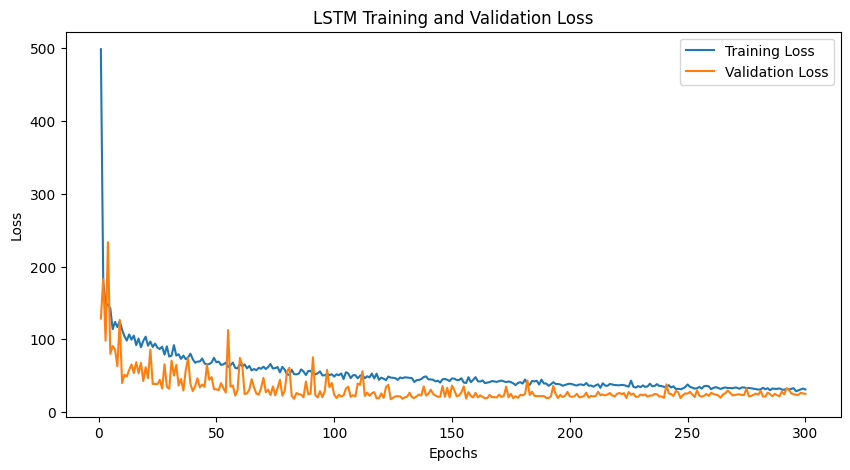

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, 300+1), train_losses, label='Training Loss')
plt.plot(range(1, 300+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training and Validation Loss')
plt.legend()
plt.show()

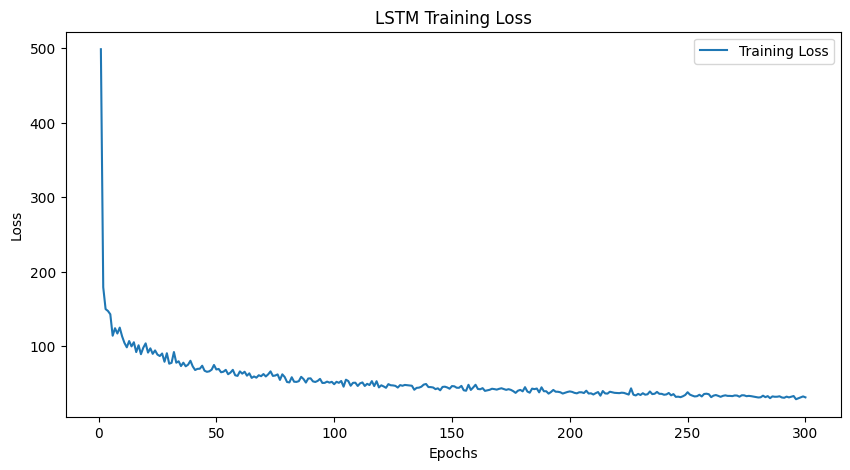

In [22]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, 300+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Training Loss')
plt.legend()
plt.show()

In [23]:
import random
def predict_and_compare(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    actuals = []
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())  
            loss = torch.sqrt(criterion(outputs, targets))
            if outputs.shape != targets.shape:
                outputs = outputs[:targets.size(0)] 
            total_loss += loss.item()
    return predictions, actuals, total_loss/len(test_loader)

test_dataset = SpeedDataset('test_outputs', sequence_length=35)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions, actuals, loss = predict_and_compare(model, test_loader)

def print_random_predictions(predictions, actuals, num_samples=30):
    if len(predictions) < num_samples:
        num_samples = len(predictions)  # Adjust sample size if predictions are fewer than requested

    # Get random sample indices
    sample_indices = random.sample(range(len(predictions)), num_samples)

    # Print the randomly selected predictions and their actual values
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]:.4f}, Actual: {actuals[idx]:.4f}")

predictions, actuals ,loss= predict_and_compare(model, test_loader)

# Now print randomly selected 30 predictions and their actual values
print_random_predictions(predictions, actuals, 50)
print("Final RMSE Loss ",loss)


Predicted: 46.2297, Actual: 47.0000
Predicted: 79.2462, Actual: 67.0000
Predicted: 52.7029, Actual: 57.0000
Predicted: 45.7315, Actual: 47.0000
Predicted: 39.6255, Actual: 38.0000
Predicted: 84.2858, Actual: 84.0000
Predicted: 79.5071, Actual: 74.0000
Predicted: 49.3655, Actual: 68.0000
Predicted: 64.4072, Actual: 61.0000
Predicted: 51.5409, Actual: 51.0000
Predicted: 78.0831, Actual: 74.0000
Predicted: 31.2390, Actual: 30.0000
Predicted: 82.4230, Actual: 84.0000
Predicted: 102.3834, Actual: 104.0000
Predicted: 41.5081, Actual: 47.0000
Predicted: 54.9867, Actual: 57.0000
Predicted: 68.9843, Actual: 69.0000
Predicted: 47.1981, Actual: 51.0000
Predicted: 37.9600, Actual: 43.0000
Predicted: 70.3307, Actual: 64.0000
Predicted: 32.5663, Actual: 30.0000
Predicted: 32.4840, Actual: 35.0000
Predicted: 70.0549, Actual: 72.0000
Predicted: 68.2674, Actual: 64.0000
Predicted: 54.7152, Actual: 67.0000
Predicted: 43.5787, Actual: 44.0000
Predicted: 37.5003, Actual: 38.0000
Predicted: 34.7509, Actual

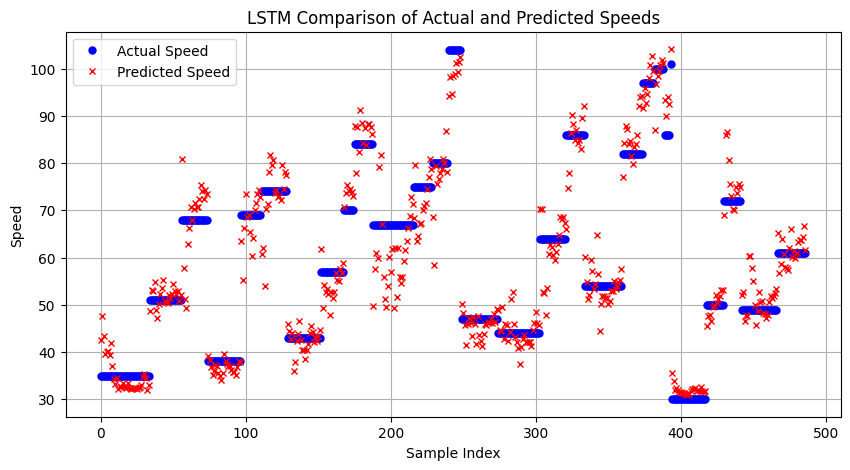

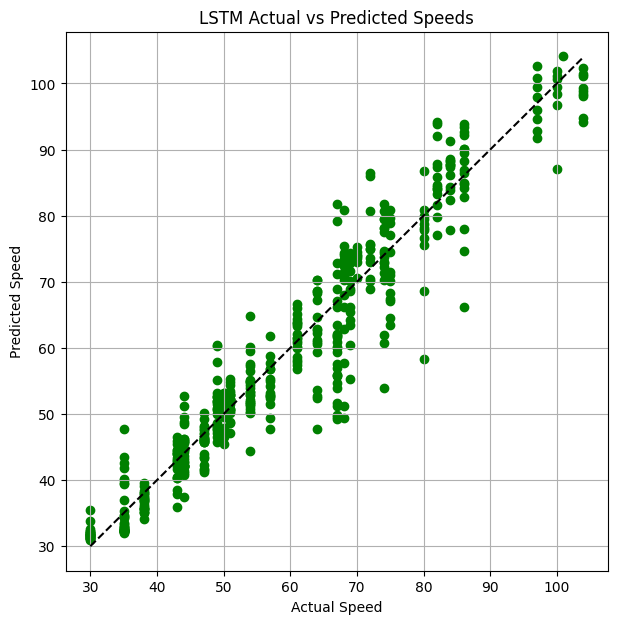

In [24]:

import matplotlib.pyplot as plt 
# Creating a plot with both predictions and actuals
plt.figure(figsize=(10, 5))

# Plotting actual speeds
plt.plot(actuals, label='Actual Speed', color='blue', marker='o', linestyle='', markersize=5)

# Plotting predicted speeds
plt.plot(predictions, label='Predicted Speed', color='red', marker='x', linestyle='', markersize=5)

plt.title('LSTM Comparison of Actual and Predicted Speeds')
plt.xlabel('Sample Index')
plt.ylabel('Speed')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot to visualize the correlation between actual and predicted speeds
plt.figure(figsize=(7, 7))
plt.scatter(actuals, predictions, color='green')
plt.title('LSTM Actual vs Predicted Speeds')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.grid(True)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')  # Diagonal line for reference
plt.show()

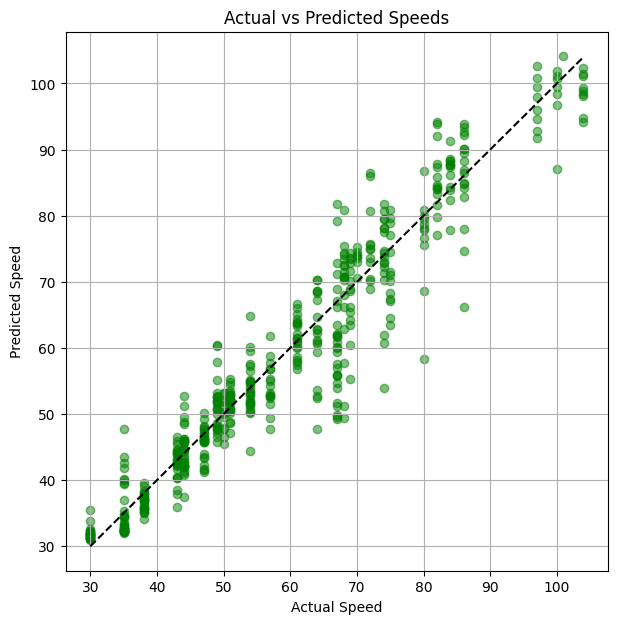

In [25]:

plt.figure(figsize=(7, 7))
plt.scatter(actuals, predictions, color='green', alpha=0.5)  # Adjust transparency with alpha
plt.title('Actual vs Predicted Speeds')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.grid(True)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')  # Diagonal line for reference
plt.show()